In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime

import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet,ElasticNetCV
from sklearn.metrics import mean_squared_error

사용할 데이터셋은 총 6가지: 
* bt_history : <2017-01-01 ~ 2021-05-07> 간의 비트코인 가격 데이터 - [종가, 시작가, 고가, 저가, 거래량]
* GLD_price : <2017-01-01 ~ 2021-05-07> 간의 국제 금 시세 + 달러-원 환율 데이터
* nikkei : <2017-01-01 ~ 2021-05-07> 간의 닛케이 지수 데이터
* shanghai : <2017-01-01 ~ 2021-05-07> 간의 상하이종합지수 데이터
* kospi : <2017-01-01 ~ 2021-05-07> 간의 코스피지수 데이터
* nasdaq : <2017-01-01 ~ 2021-05-07> 간의 나스닥지수 데이터

In [2]:
# 데이터셋 로드
bt = pd.read_csv('../data/bt_history.csv', index_col = 'Date', parse_dates = True)
gld = pd.read_csv('../data/GLD_price.csv', index_col = 'Date', parse_dates = True)
nk = pd.read_csv('../data/nikkei.csv', index_col = 'Date', parse_dates = True)
sh = pd.read_csv('../data/shanghai.csv', index_col = 'Date', parse_dates = True)
kospi = pd.read_csv('../data/kospi.csv', index_col = 'Date', parse_dates = True)
nasdaq = pd.read_csv('../data/nasdaq.csv', index_col = 'Date', parse_dates = True)

In [3]:
bt.head(3)

,Close,Open,High,Low,Volue_K,Volume
Date,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41.15,41150.0
2017-01-02,1017.0,995.4,1031.7,990.2,64.95,64950.0
2017-01-03,1033.3,1017.0,1035.5,1006.5,54.79,54790.0


In [4]:
gld.head(3)

,GLD_Price,USD_KRW
Date,,
2017-01-02,1151.67,1209.0
2017-01-03,1151.35,1206.0
2017-01-04,1164.23,1203.0


In [5]:
nk.head(3)

,Nikkei
Date,
2017-01-04,19594.16
2017-01-05,19520.69
2017-01-06,19454.33


In [6]:
sh.head(3)

,Shanghai
Date,
2017-01-03,3135.92
2017-01-04,3158.79
2017-01-05,3165.41


In [7]:
kospi.head(3)

,KOSPI
Date,
2017-01-02,2026.16
2017-01-03,2043.97
2017-01-04,2045.64


In [8]:
nasdaq.head(3)

,Nasdaq
Date,
2017-01-03,5429.08
2017-01-04,5477.01
2017-01-05,5487.94


* bt: 매일마다 관측치가 존재
* 나머지 데이터셋: 불규칙하게 존재
* pd.concat -> join='outer'로 결합

In [9]:
df_1 = pd.concat([bt, gld], join='outer', axis=1)

In [10]:
df_2 = pd.concat([df_1, nk], join='outer', axis=1)

In [11]:
df_3 = pd.concat([df_2, sh], join='outer', axis=1)

In [12]:
df_4 = pd.concat([df_3, kospi], join='outer', axis=1)

In [13]:
df_5 = pd.concat([df_4, nasdaq], join='outer', axis=1)

In [14]:
df = df_5
df.head()

,Close,Open,High,Low,Volue_K,Volume,GLD_Price,USD_KRW,Nikkei,Shanghai,KOSPI,Nasdaq
Date,,,,,,,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41.15,41150.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1017.0,995.4,1031.7,990.2,64.95,64950.0,1151.67,1209.0,NaN,NaN,2026.16,NaN
2017-01-03,1033.3,1017.0,1035.5,1006.5,54.79,54790.0,1151.35,1206.0,NaN,3135.92,2043.97,5429.08
2017-01-04,1135.4,1033.3,1148.5,1022.3,156.27,156270.0,1164.23,1203.0,19594.16,3158.79,2045.64,5477.01
2017-01-05,989.3,1135.4,1150.6,874.5,240.01,240010.0,1172.59,1188.0,19520.69,3165.41,2041.95,5487.94


### 데이터타입 확인하기

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1588 entries, 2017-01-01 to 2021-05-07
Freq: D
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      1588 non-null   float64
 1   Open       1588 non-null   float64
 2   High       1588 non-null   float64
 3   Low        1588 non-null   float64
 4   Volue_K    1588 non-null   float64
 5   Volume     1588 non-null   float64
 6   GLD_Price  1071 non-null   float64
 7   USD_KRW    1071 non-null   float64
 8   Nikkei     1088 non-null   float64
 9   Shanghai   1055 non-null   float64
 10  KOSPI      1067 non-null   float64
 11  Nasdaq     1094 non-null   float64
dtypes: float64(12)
memory usage: 161.3 KB


### 결측치의 처리

In [16]:
df.isnull().sum()

Close          0
Open           0
High           0
Low            0
Volue_K        0
Volume         0
GLD_Price    517
USD_KRW      517
Nikkei       500
Shanghai     533
KOSPI        521
Nasdaq       494
dtype: int64

In [17]:
def fmissing(df):
    for col in df.columns:
        df[col] = df[col].interpolate()
    print(f'No. of Missing Values after interpolation:\n{df.isnull().sum()}')

In [18]:
fmissing(df)

No. of Missing Values after interpolation:
Close        0
Open         0
High         0
Low          0
Volue_K      0
Volume       0
GLD_Price    1
USD_KRW      1
Nikkei       3
Shanghai     2
KOSPI        1
Nasdaq       2
dtype: int64


In [19]:
df.head()

,Close,Open,High,Low,Volue_K,Volume,GLD_Price,USD_KRW,Nikkei,Shanghai,KOSPI,Nasdaq
Date,,,,,,,,,,,,
2017-01-01,995.4,963.4,1001.6,956.1,41.15,41150.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,1017.0,995.4,1031.7,990.2,64.95,64950.0,1151.67,1209.0,NaN,NaN,2026.16,NaN
2017-01-03,1033.3,1017.0,1035.5,1006.5,54.79,54790.0,1151.35,1206.0,NaN,3135.92,2043.97,5429.08
2017-01-04,1135.4,1033.3,1148.5,1022.3,156.27,156270.0,1164.23,1203.0,19594.16,3158.79,2045.64,5477.01
2017-01-05,989.3,1135.4,1150.6,874.5,240.01,240010.0,1172.59,1188.0,19520.69,3165.41,2041.95,5487.94


* 보간법을 사용했으므로 맨 앞 3번째까지는 여전히 결측치로 존재

In [20]:
df.dropna(inplace=True)

In [21]:
df.isnull().sum()

Close        0
Open         0
High         0
Low          0
Volue_K      0
Volume       0
GLD_Price    0
USD_KRW      0
Nikkei       0
Shanghai     0
KOSPI        0
Nasdaq       0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1585 entries, 2017-01-04 to 2021-05-07
Freq: D
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      1585 non-null   float64
 1   Open       1585 non-null   float64
 2   High       1585 non-null   float64
 3   Low        1585 non-null   float64
 4   Volue_K    1585 non-null   float64
 5   Volume     1585 non-null   float64
 6   GLD_Price  1585 non-null   float64
 7   USD_KRW    1585 non-null   float64
 8   Nikkei     1585 non-null   float64
 9   Shanghai   1585 non-null   float64
 10  KOSPI      1585 non-null   float64
 11  Nasdaq     1585 non-null   float64
dtypes: float64(12)
memory usage: 161.0 KB


# EDA

In [23]:
df.drop('Volue_K', axis=1, inplace=True)

<AxesSubplot:>

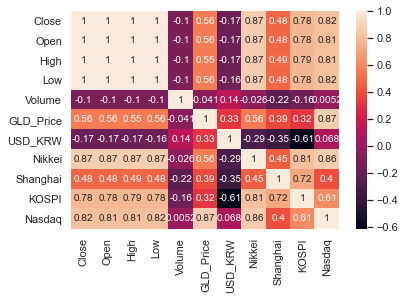

In [24]:
sns.heatmap(df.corr(), annot=True)

* Target: "Close"
* Open, High, Low 컬럼은 상관계수가 1 - Close와 같이 움직인다 + 시작가/고가/저가 데이터가 종가에 영향을 미치지 않는다고 판단 -> 삭제

In [25]:
df.drop(['Open','High','Low'], axis=1, inplace=True)

In [26]:
df.columns

Index(['Close', 'Volume', 'GLD_Price', 'USD_KRW', 'Nikkei', 'Shanghai',
       'KOSPI', 'Nasdaq'],
      dtype='object')

In [27]:
df.head()

,Close,Volume,GLD_Price,USD_KRW,Nikkei,Shanghai,KOSPI,Nasdaq
Date,,,,,,,,
2017-01-04,1135.4,156270.0,1164.23,1203.000000,19594.1600,3158.79,2045.640000,5477.010000
2017-01-05,989.3,240010.0,1172.59,1188.000000,19520.6900,3165.41,2041.950000,5487.940000
2017-01-06,886.2,194290.0,1176.25,1193.500000,19454.3300,3154.32,2049.120000,5521.060000
2017-01-07,888.9,130660.0,1176.45,1197.666667,19416.1075,3159.96,2049.006667,5524.646667
2017-01-08,900.9,76910.0,1176.65,1201.833333,19377.8850,3165.60,2048.893333,5528.233333


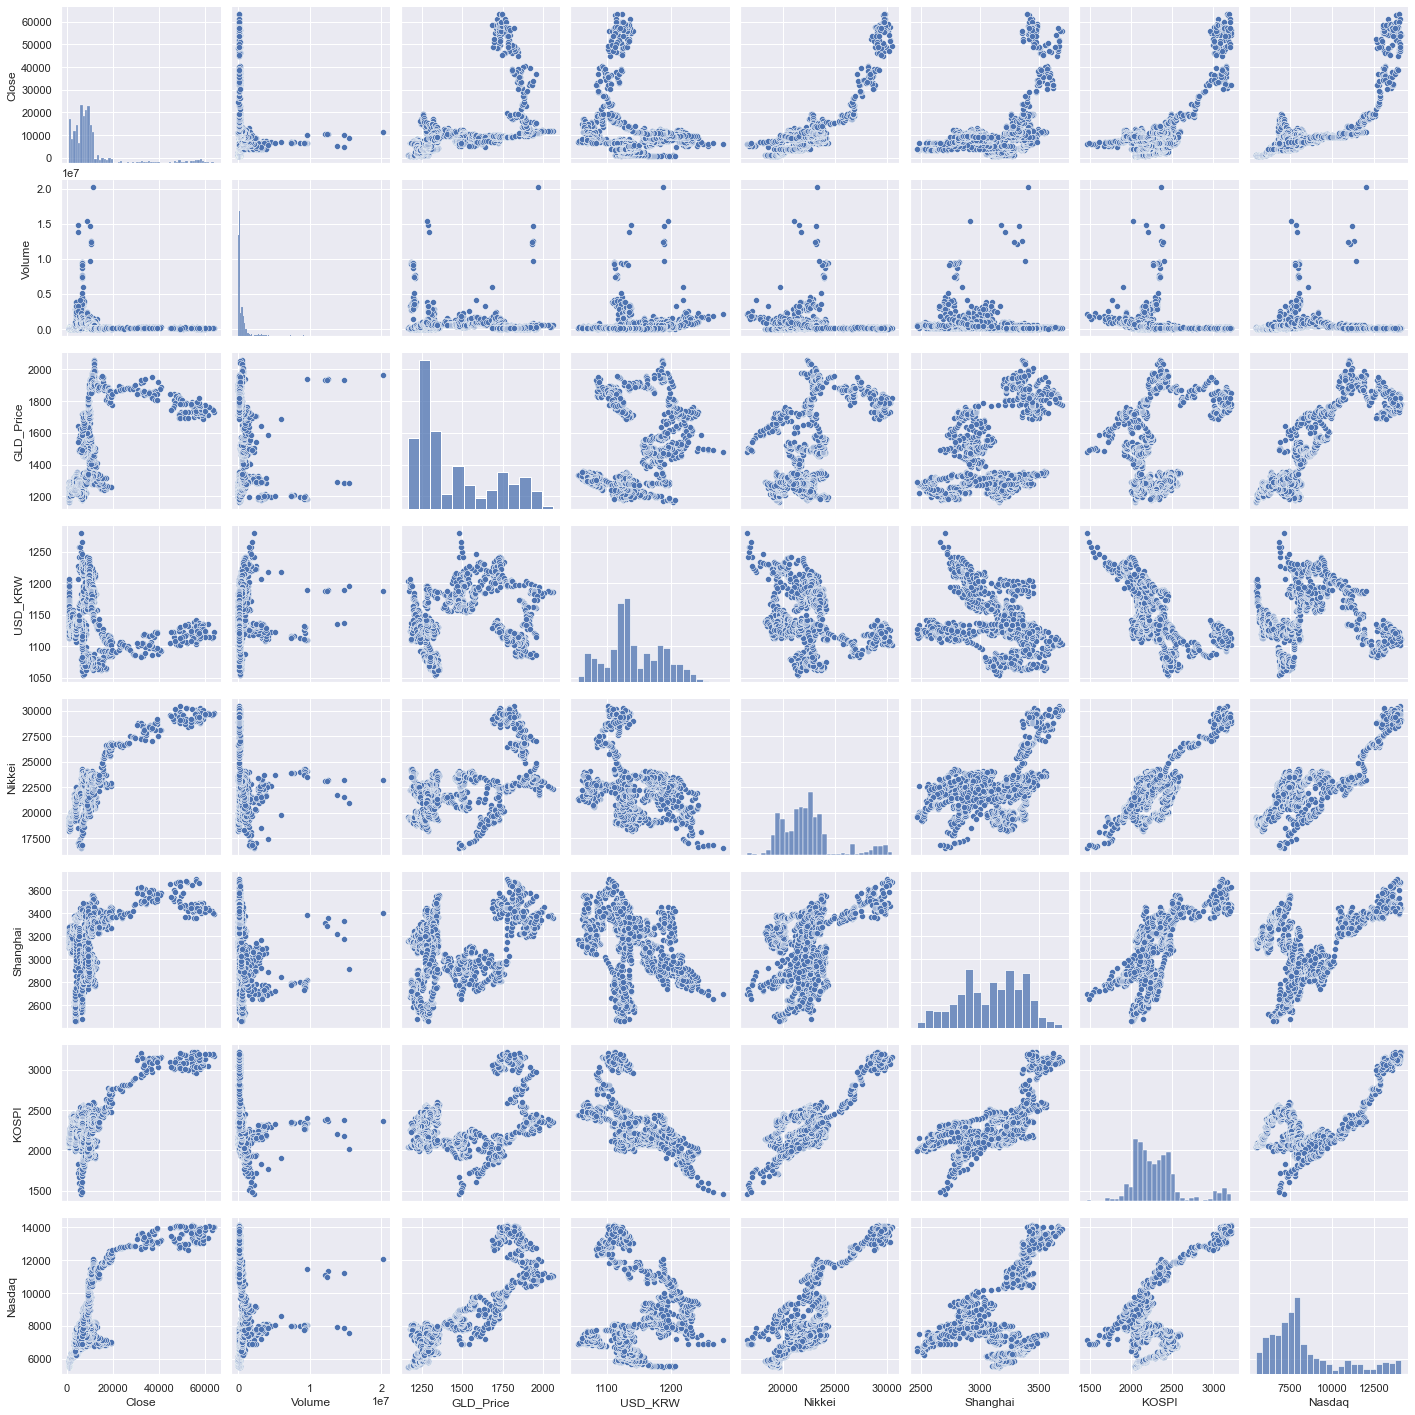

In [28]:
sns.pairplot(df)

<AxesSubplot:>

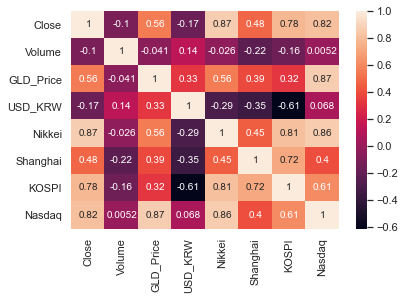

In [29]:
sns.heatmap(df.corr(), annot=True)

# 회귀모형

In [30]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [31]:
x = df.iloc[:, 1:]
y = df['Close']

In [389]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 33)

In [390]:
model_ols = sm.OLS(y_train, x_train)
result_ols = model_ols.fit()
print(result_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.889
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              1259.
Date:                Sat, 05 Jun 2021   Prob (F-statistic):                        0.00
Time:                        13:06:56   Log-Likelihood:                         -11102.
No. Observations:                1109   AIC:                                  2.222e+04
Df Residuals:                    1102   BIC:                                  2.225e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 상수항 추가

In [391]:
x_train_add = sm.add_constant(x_train)

In [392]:
x_test_add = sm.add_constant(x_test)

In [393]:
model_ols2 = sm.OLS(y_train, x_train_add)
result_ols2 = model_ols2.fit()

In [394]:
print(result_ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     872.2
Date:                Sat, 05 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:06:58   Log-Likelihood:                -10965.
No. Observations:                1109   AIC:                         2.195e+04
Df Residuals:                    1101   BIC:                         2.199e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.676e+05   9559.791    -17.530      0.0

### 정규성 가정 검정

In [395]:
import scipy as sp

#표준화 잔차 
student_residuals = pd.Series(result_ols2.get_influence().resid_studentized_internal)
student_residuals = student_residuals.sort_values(ascending = True)
dd = pd.DataFrame(student_residuals)
dd.columns = ['student_residuals']


dd['theoretical_quantiles'] = sp.stats.probplot(dd['student_residuals'], dist = 'norm', fit = False)[0]
#output : Tuple of theoretical quantiles, Tuple containing the result of the least-squares fit

XX = dd['theoretical_quantiles']
YY = dd['student_residuals']
dd.head()


,student_residuals,theoretical_quantiles
107,-2.430117,-3.227299
464,-2.313688,-2.964346
153,-2.289152,-2.817753
1057,-2.181455,-2.714433
202,-1.957395,-2.633871


<AxesSubplot:title={'center':'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

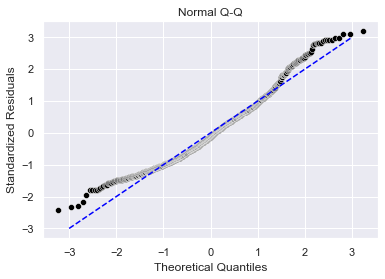

In [396]:
## normal qq plot 
plt.rcParams.update({'font.size': 16})

plt.rcParams.update({'font.size': 16})
ax= sns.scatterplot(XX,YY, color='black')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
sns.lineplot([-3,3], [-3,3], ls= '--',color='blue' )


* 컷을 1.96으로 하면 얼추 정규성 가진다고 할 수 있을까...? 조금 애매하긴 하다

### 예측력 평가

In [397]:
y_pred_ols2 = result_ols2.predict(x_test_add)

In [398]:
pred_y2 = result_ols2.predict(x_test_add)
mse2 = mean_squared_error(y_test, pred_y2)

In [399]:
print(mse2)

21550635.616302386


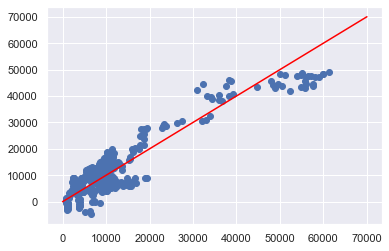

In [400]:
df2 = pd.DataFrame({'Actual':y_test, 'Predicted':pred_y2})

plt.scatter(x = df2['Actual'], y = df2['Predicted'])
plt.plot(np.arange(0, 70000), np.arange(0, 70000), color = "red")
plt.show()

In [401]:
df2.corr()

,Actual,Predicted
Actual,1.000000,0.926552
Predicted,0.926552,1.000000


### 정규화 메소드 적용: ridge, lasso, elasticnet -> cv

In [402]:
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

* Ridge

In [403]:
for a in alphas:
    model_ridge = Ridge(alpha=a).fit(x_train_add,y_train)
    score_ridge = model_ridge.score(x_train_add, y_train)
    pred_y_ridge = model_ridge.predict(x_test_add)
    mse_ridge = mean_squared_error(y_test, pred_y_ridge)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score_ridge, mse_ridge, np.sqrt(mse_ridge)))

Alpha:0.0001, R2:0.85, MSE:21550635.62, RMSE:4642.27
Alpha:0.0005, R2:0.85, MSE:21550635.62, RMSE:4642.27
Alpha:0.0010, R2:0.85, MSE:21550635.62, RMSE:4642.27
Alpha:0.0050, R2:0.85, MSE:21550635.61, RMSE:4642.27
Alpha:0.0100, R2:0.85, MSE:21550635.60, RMSE:4642.27
Alpha:0.0500, R2:0.85, MSE:21550635.56, RMSE:4642.27
Alpha:0.1000, R2:0.85, MSE:21550635.50, RMSE:4642.27
Alpha:0.5000, R2:0.85, MSE:21550635.02, RMSE:4642.27
Alpha:1.0000, R2:0.85, MSE:21550634.43, RMSE:4642.27


C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.89966e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94983e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.89966e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.94983e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.89966e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\li

In [404]:
ridge_cv=RidgeCV(alphas=alphas, cv=10)
model = ridge_cv.fit(x_train_add, y_train)
print(model.alpha_)

C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.38213e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.15481e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.0536e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.03663e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.1192e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\workspace\lib\

1.0


In [405]:
ridge=Ridge(alpha=1.0).fit(x_train_add, y_train)
ypred_ridge = ridge.predict(x_test_add)
score_ridge = ridge.score(x_test_add, y_test)
mse_ridge = mean_squared_error(y_test, ypred_ridge)
print("Final Result: Ridge R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
.format(score_ridge, mse_ridge, np.sqrt(mse_ridge)))

Final Result: Ridge R2:0.857, MSE:21550634.43, RMSE:4642.27


* Lasso

In [406]:
for a in alphas:
    model = Lasso(alpha=a).fit(x_train_add,y_train)
    score = model.score(x_train_add, y_train)
    pred_y = model.predict(x_test_add)
    mse = mean_squared_error(y_test, pred_y)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.85, MSE:21550635.61, RMSE:4642.27
Alpha:0.0005, R2:0.85, MSE:21550635.60, RMSE:4642.27
Alpha:0.0010, R2:0.85, MSE:21550635.59, RMSE:4642.27
Alpha:0.0050, R2:0.85, MSE:21550635.50, RMSE:4642.27
Alpha:0.0100, R2:0.85, MSE:21550635.38, RMSE:4642.27
Alpha:0.0500, R2:0.85, MSE:21550634.44, RMSE:4642.27
Alpha:0.1000, R2:0.85, MSE:21550633.26, RMSE:4642.27
Alpha:0.5000, R2:0.85, MSE:21550623.84, RMSE:4642.26
Alpha:1.0000, R2:0.85, MSE:21550612.08, RMSE:4642.26


In [407]:
lasso_cv=LassoCV(alphas=alphas, cv=10)
model = lasso_cv.fit(x_train_add, y_train)
print(model.alpha_)

0.0001


In [408]:
lasso=Lasso(alpha=0.0001).fit(x_train_add, y_train)
ypred_lasso = lasso.predict(x_test_add)
score_lasso = lasso.score(x_test_add, y_test)
mse_lasso = mean_squared_error(y_test, ypred_lasso)
print("Final Result: Lasso R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
.format(score_lasso, mse_lasso, np.sqrt(mse_lasso)))

Final Result: Lasso R2:0.857, MSE:21550635.61, RMSE:4642.27


* ElasticNet

In [409]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(x_train_add,y_train)
    score = model.score(x_train_add, y_train)
    pred_y = model.predict(x_test_add)
    mse = mean_squared_error(y_test, pred_y)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.85, MSE:21550635.55, RMSE:4642.27
Alpha:0.0005, R2:0.85, MSE:21550635.28, RMSE:4642.27
Alpha:0.0010, R2:0.85, MSE:21550634.95, RMSE:4642.27
Alpha:0.0050, R2:0.85, MSE:21550632.27, RMSE:4642.27
Alpha:0.0100, R2:0.85, MSE:21550628.93, RMSE:4642.27
Alpha:0.0500, R2:0.85, MSE:21550602.20, RMSE:4642.26
Alpha:0.1000, R2:0.85, MSE:21550568.81, RMSE:4642.26
Alpha:0.5000, R2:0.85, MSE:21550302.80, RMSE:4642.23
Alpha:1.0000, R2:0.85, MSE:21549973.06, RMSE:4642.19


In [410]:
elastic_cv=ElasticNetCV(alphas=alphas, cv=10)
model = elastic_cv.fit(x_train_add, y_train)
print(model.alpha_)

1.0


In [411]:
elastic=ElasticNet(alpha=1.0).fit(x_train_add, y_train)
ypred_elastic = elastic.predict(x_test_add)
score_elastic = elastic.score(x_test_add, y_test)
mse_elastic = mean_squared_error(y_test, ypred_elastic)
print("Final Result: ElasticNet R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}"
.format(score_elastic, mse_elastic, np.sqrt(mse_elastic)))

Final Result: ElasticNet R2:0.857, MSE:21549973.06, RMSE:4642.19


In [412]:
print("<<<<Model Comparison>>>>")
print("\n---- Base LR ----")
print("[Regression] R2:0.856, MSE:",round(mse2, 3), "RMSE:",round(np.sqrt(mse2), 2))
print("\n---- Normalize Methods ----")
print("[Ridge] R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}".format(score_ridge, mse_ridge, np.sqrt(mse_ridge)))
print("[Lasso] R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}".format(score_lasso, mse_lasso, np.sqrt(mse_lasso)))
print("[ElasticNet] R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}".format(score_elastic, mse_elastic, np.sqrt(mse_elastic)))

<<<<Model Comparison>>>>

---- Base LR ----
[Regression] R2:0.856, MSE: 21550635.616 RMSE: 4642.27

---- Normalize Methods ----
[Ridge] R2:0.857, MSE:21550634.43, RMSE:4642.27
[Lasso] R2:0.857, MSE:21550635.61, RMSE:4642.27
[ElasticNet] R2:0.857, MSE:21549973.06, RMSE:4642.19


* 최종 모델은 ElasticNet으로 하자

### 최종 모델 성능

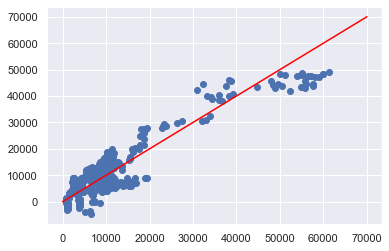

In [413]:
df_en = pd.DataFrame({'Actual':y_test, 'Predicted':ypred_elastic})

plt.scatter(x = df_en['Actual'], y = df_en['Predicted'])
plt.plot(np.arange(0, 70000), np.arange(0, 70000), color = "red")
plt.show()

In [414]:
df_en.corr()

,Actual,Predicted
Actual,1.000000,0.926554
Predicted,0.926554,1.000000


In [415]:
elastic.coef_

array([ 0.00000000e+00, -5.98047335e-04, -1.66276938e+01,  9.46618940e+01,
        6.60884352e-01, -2.24187182e+00,  2.55759251e+01,  3.33091515e+00])

In [416]:
df_en.corr()

,Actual,Predicted
Actual,1.000000,0.926554
Predicted,0.926554,1.000000


# DT, RF

In [417]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.tree import export_graphviz  
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
import pydotplus
from IPython.display import Image
import os 
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz 2.44.1/bin/'

## DT
* RF 하기 전에 DT도 한번 해보기는 하자

In [418]:
def performance_metric(y_true, y_predict):
    error = metrics.mean_squared_error(y_true, y_predict)
    return error

In [419]:
def fit_model(data, target):
    regressor = DecisionTreeRegressor()
    param_grid = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}
    scoring_fnc = metrics.make_scorer(performance_metric, False)
    reg = GridSearchCV(regressor, param_grid, scoring = scoring_fnc, cv=3)
    reg.fit(data, target)
    return reg.best_estimator_

In [420]:
regtree = fit_model(x_train, y_train)

In [421]:
pred_regtree = regtree.predict(x_test)

In [422]:
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True)
y_test_df.head()

,Date,Close
0,2018-09-18,6342.0
1,2021-04-27,55036.5
2,2021-01-10,38192.2
3,2018-10-06,6596.3
4,2019-08-05,11816.8


### DT 시각화

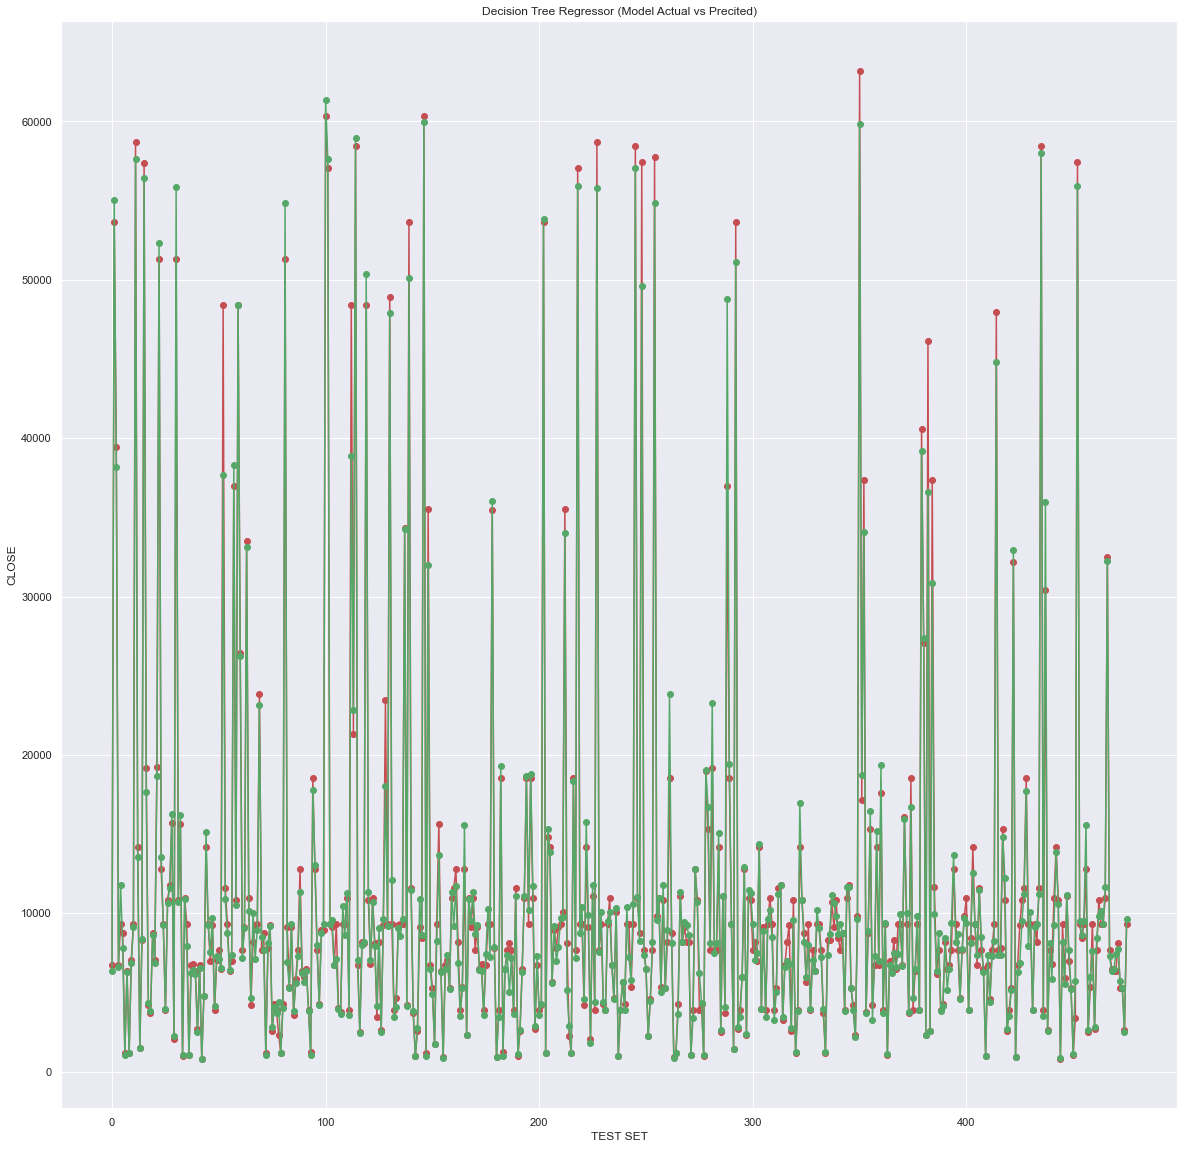

In [423]:
plt.figure(figsize=(20,20))
plt.title("Decision Tree Regressor (Model Actual vs Precited)")
plt.xlabel('TEST SET')
plt.ylabel('CLOSE')
plt.plot(pred_regtree, 'o-', color="r", label="Predicted CLOSE")
plt.plot(y_test_df['Close'], 'o-', color="g", label="Actual CLOSE")

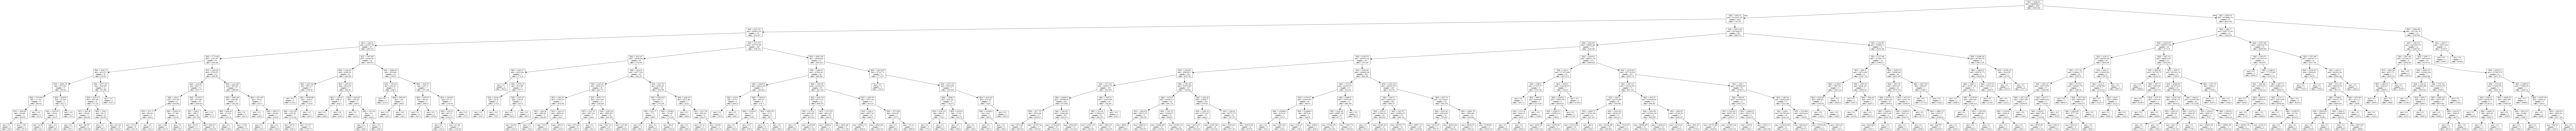

In [424]:
export_graphviz(regtree, out_file ='tree.dot') 
with open("tree.dot") as f:
    dot_graph = f.read()

# remove the display(...)
pydot_graph = pydotplus.graph_from_dot_file("tree.dot")
Image(pydot_graph.create_png())

In [425]:
mse_dt = mean_squared_error(y_test, pred_regtree)
print(mse_dt)

2217143.216648619


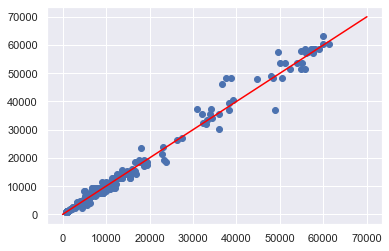

In [426]:
df_dt = pd.DataFrame({'Actual':y_test, 'Predicted':pred_regtree})

plt.scatter(x = df_dt['Actual'], y = df_dt['Predicted'])
plt.plot(np.arange(0, 70000), np.arange(0, 70000), color = "red")
plt.show()

In [427]:
df_dt.corr()

,Actual,Predicted
Actual,1.000000,0.993023
Predicted,0.993023,1.000000


* 총평: MSE는 회귀에 비해 엄청 줄어들었다!

## RF

In [428]:
nTreeList = range(10, 1000, 10)
mseOos = []

for iTrees in nTreeList:
    depth = None
    maxFeat = 2
    rf = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    rf.fit(x_train, y_train)

    prediction = rf.predict(x_test)
    mseOos.append(mean_squared_error(y_test, prediction))
    print(iTrees,' : ',mean_squared_error(y_test, prediction))
print('<< LeastMse RF >>\n')
print(min(mseOos))

10  :  2064004.6004691178
20  :  1488655.7750419623
30  :  1326255.6838253716
40  :  1383310.0160193914
50  :  1331322.4155610076
60  :  1364147.749860715
70  :  1346500.3412363634
80  :  1248347.6702583968
90  :  1250278.6459527446
100  :  1279439.467434002
110  :  1330184.5019324597
120  :  1313001.97600278
130  :  1293589.005511701
140  :  1278080.591110002
150  :  1282580.6755642174
160  :  1292532.5224921608
170  :  1290621.8343078175
180  :  1269273.2917700275
190  :  1269356.0182210966
200  :  1261001.9663608836
210  :  1262263.7813435392
220  :  1278558.0976210078
230  :  1262440.0920636184
240  :  1277045.6477657054
250  :  1283358.6591817557
260  :  1288009.2982632807
270  :  1299726.9581643636
280  :  1297773.4880023696
290  :  1292363.8134541763
300  :  1279755.5552956176
310  :  1285641.9503536455
320  :  1287856.3978492527
330  :  1286873.4028881355
340  :  1284898.2772692498
350  :  1278115.3607607374
360  :  1289873.8978943022
370  :  1284592.9753390192
380  :  1282808.

### max_feat = 3

In [429]:
nTreeList = range(10, 1000, 10)
mseOos1 = []

for iTrees in nTreeList:
    depth = None
    maxFeat = 3
    rf = ensemble.RandomForestRegressor(n_estimators=iTrees,
                    max_depth=depth, max_features=maxFeat,
                    oob_score=False, random_state=531)
    rf.fit(x_train, y_train)

    prediction = rf.predict(x_test)
    mseOos1.append(mean_squared_error(y_test, prediction))
    print(iTrees,' : ',mean_squared_error(y_test, prediction))
print('<< LeastMse RF >>\n')
print(min(mseOos1))

10  :  1784324.03852164
20  :  1376331.8263676986
30  :  1308487.8254038745
40  :  1358345.8952874593
50  :  1305300.3233804458
60  :  1222177.5090513728
70  :  1219756.2440902153
80  :  1139364.99922392
90  :  1133377.262626409
100  :  1100294.4310414232
110  :  1111691.8535079623
120  :  1099091.2715252333
130  :  1105887.5703186647
140  :  1071227.665092569
150  :  1066831.738765832
160  :  1094307.3347153093
170  :  1077996.103243145
180  :  1074165.4295740714
190  :  1085211.336624397
200  :  1083343.8509022982
210  :  1099673.823790905
220  :  1105337.3450962405
230  :  1104125.6969271726
240  :  1109501.0158711397
250  :  1109632.963404977
260  :  1129286.9753321935
270  :  1124836.3628870123
280  :  1102079.5575534112
290  :  1112025.0151864414
300  :  1109860.0464022658
310  :  1106636.1706689198
320  :  1095272.9801866775
330  :  1089513.0078797978
340  :  1093955.931827575
350  :  1086805.2424907715
360  :  1090895.8905744608
370  :  1093794.3238628537
380  :  1093629.706327

max_features = 3, n_estimators = 150일 때 가장 베스트 모델

### Best RF Modeling

In [430]:
RF = ensemble.RandomForestRegressor(n_estimators=150,
                    max_depth=None, max_features=3,
                    oob_score=False, random_state=531)
RF.fit(x_train, y_train)

pred_rf = RF.predict(x_test)

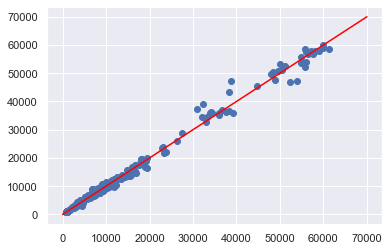

In [431]:
df_rf = pd.DataFrame({'Actual':y_test, 'Predicted':pred_rf})

plt.scatter(x = df_rf['Actual'], y = df_rf['Predicted'])
plt.plot(np.arange(0, 70000), np.arange(0, 70000), color = "red")
plt.show()

In [432]:
df_rf.corr()

,Actual,Predicted
Actual,1.000000,0.996473
Predicted,0.996473,1.000000


In [433]:
print(mean_squared_error(y_test, pred_rf))

1066831.738765832


### 변수 중요도 파악

In [434]:
feature_names = np.array(df.columns[1:])
feature_names

array(['Volume', 'GLD_Price', 'USD_KRW', 'Nikkei', 'Shanghai', 'KOSPI',
       'Nasdaq'], dtype=object)

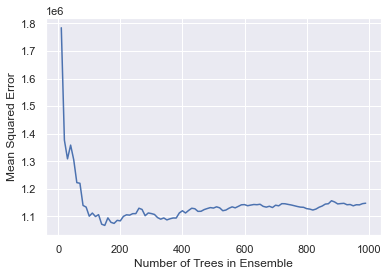

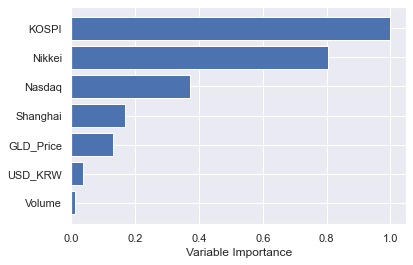

In [435]:
plt.plot(nTreeList, mseOos1)
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('Mean Squared Error')
#plt.ylim([0.0, 1.1*max(mseOob1)])
plt.show()

#피처 중요도 도표 그리기
featureImportance = RF.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, feature_names[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

# Prediction: current_data

In [436]:
# data of 2021.06.05

x_curr = np.array([310200, 1877.98, 1127.00, 28364.61, 3497.28, 3144.30, 13588.34])
y_curr = np.array(37824.9)

In [437]:
pred_curr = RF.predict(x_curr.reshape(1,-1))
print("[Actual]: ",y_curr, "\n[Prediction]: ",pred_curr, "\n[Residual]: ", y_curr - pred_curr, 
      "\n[Residual_per]: ", (y_curr - pred_curr)/y_curr*100)

[Actual]:  37824.9 
[Prediction]:  [37451.38] 
[Residual]:  [373.52] 
[Residual_per]:  [0.98749765]
